In [301]:
import os
import random

import numpy as np
import cv2
import matplotlib.patches as mpatches

from PIL import Image
from matplotlib import pyplot as plt
from skimage import data, util
from skimage.measure import label, regionprops

In [302]:
BARREL_PATH = "./labeled_train_mike/"
IMG_PATH = './2019Proj1_train/'

plt.figure(figsize=(20,20))

xtrain = []

labeled_files = os.listdir(BARREL_PATH)

random.shuffle(labeled_files)
train_files = labeled_files[:44]
test_files = labeled_files[44:]

print(train_files)
print(test_files)

for filename in train_files:
    basename, extension = os.path.splitext(filename)
    if (extension != ".npy"):
        continue
    redbarrel = np.load(BARREL_PATH+filename)
    img = cv2.imread(IMG_PATH+basename+'.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    tmp = img[redbarrel]
    
    for j in range(tmp.shape[0]):
        xtrain.append(tmp[j, :])

xtrain = np.array(xtrain)
print(np.shape(xtrain))

['6.5.npy', '14.npy', '4.8.npy', '4.5.npy', '4.6.npy', '6.1.npy', '5.1.npy', '8.3.npy', '3.8.npy', '3.4.npy', '10.4.npy', '9.2.npy', '5.3.npy', '8.4.npy', '2.14.npy', '2.2.npy', '5.9.npy', '4.7.npy', '3.10.npy', '10.1.npy', '6.3.npy', '7.3.npy', '4.3.npy', '6.6.npy', '2_3.1.npy', '4.10.npy', '5.11.npy', '5.6.npy', '4.2.npy', '6.4.npy', '7.2.npy', '4.4.npy', '3.11.npy', '5.4.npy', '8.2.npy', '6.7.npy', '6.8.npy', '4.1.npy', '3.1.npy', '5.10.npy', '7.6.npy', '2.8.npy', '5.2.npy', '8.5.npy']
['5.5.npy', '3.2.npy', '2.3.npy', '2.6.npy', '7.4.npy']
(704782, 3)


<Figure size 1440x1440 with 0 Axes>

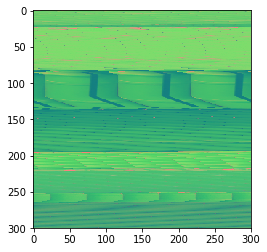

In [303]:
img_train_reshape = np.reshape(xtrain[:90000, :], (300, 300, 3))
np.shape(img_train_reshape)
plt.imshow(img_train_reshape)

In [304]:
def scale(pixels):
    scaled_pixels = list(pixels)

    for i in range(len(scaled_pixels)):
        scaled_pixels[i] = scaled_pixels[i] / 256.0

    scaled_pixels = np.array(scaled_pixels)
    
    return scaled_pixels

In [305]:
from scipy.stats import multivariate_normal

class GMM_EM:
    def __init__(self, K, data, threshold):
        self.K = K
        self.data = data
        self.data_size, self.dimensions = self.data.shape
        self.threshold = threshold
        
        self.mus = np.random.rand(self.K, self.dimensions)
        
        self.covs = []
        cov_diags = np.random.rand(self.K, self.dimensions)
        for diag in cov_diags:
            self.covs.append(np.diag(diag))
        self.covs = np.array(self.covs)
        
        pis = []
        remain = 1
        for rand in np.random.rand(self.K - 1):
            pis.append(rand)
            remain -= remain * rand
        pis.append(remain)
        self.pis = np.array(pis)
        
    def __E_step(self):
        # p(x|k) - prior probability
        prob_x_k = np.zeros((self.data_size, self.K))
        for k in range(self.K):
            prob_x_k[:, k] = multivariate_normal.pdf(self.data, mean=self.mus[k], cov=self.covs[k])
        
        # p(k|x) - gamma - responsibility
        prob_k_x = np.zeros((self.data_size, self.K))
        
        # numerator = p(k) * p(x|k) 
        for k in range(self.K):
            prob_k_x[:, k] = self.pis[k] * prob_x_k[:, k]
            
        # denomenator = p(x) = sum of all p(k) * p(x|k)
        for i in range(self.data_size):
            p_x = np.sum(prob_k_x[i, :])
            prob_k_x[i, :] /= p_x
        
        return prob_k_x
        
    def __M_step(self, gammas):
        mus_new = np.zeros((self.K, self.dimensions))
        covs_new = []
        pis_new = np.zeros(self.K)
        
        # update weights, means and variances for each model
        for k in range(self.K):
            # sum of gammas
            sum_gamma = np.sum(gammas[:, k])
            
            # mean
            for f in range(self.dimensions):
                mus_new[k, f] = np.sum(np.multiply(gammas[:, k], self.data[:, f])) / np.sum(gammas[:, k])
                
            # cov
            cov_diag = np.zeros(self.dimensions)
            for f in range(self.dimensions):
                cov_diag[f] = np.sum(np.multiply(gammas[:, k], np.square(self.data[:, f] - self.mus[k, f])))
            
            cov_diag /= np.sum(gammas[:, k])
            covs_new.append(np.diag(cov_diag))
            
            # pi
            pis_new[k] = np.sum(gammas[:, k] / self.data_size)
        
        self.mus = mus_new
        self.covs = covs_new
        self.pis = pis_new
    
    def set_mu(self, mus):
        self.mus = mus
        
    def set_covs(self, covs):
        self.covs = covs
        
    def iterate(self):
#         print("-------------------------------------------------------")
#         print("Parameters initialized:", "mus:", self.mus, "covs:", self.covs, "pis:", self.pis, sep="\n")
        
        iteration = 0
        log_likelihoods = []
        
        mus_tracker = [[[] for f in range(self.dimensions)] for k in range(self.K)]
        while iteration < 500:
            iteration += 1
            
            for k in range(self.K):
                for f in range(self.dimensions):
                    mus_tracker[k][f].append(self.mus[k][f])
            
            # E-step
            gammas = self.__E_step()
            
            # M-step
            self.__M_step(gammas)
            
            likelihood = np.zeros(self.data_size)

            for k in range(self.K):
                likelihood += multivariate_normal.pdf(self.data, self.mus[k], self.covs[k]) * self.pis[k]

            log_likelihoods.append(np.sum(np.log10(likelihood)))
            
            # noise resistance
            if iteration > 5 and \
               abs(np.mean(log_likelihoods[iteration - 2 : iteration]) - \
                   np.mean(log_likelihoods[iteration - 5 : iteration - 2])) \
               / abs(log_likelihoods[-1]) < self.threshold:
                break
        
        return mus_tracker, iteration

In [306]:
em_model = GMM_EM(5, scale(xtrain), 0.001)
mus_tracker, iteration = em_model.iterate()

In [307]:
print(em_model.mus)
print(em_model.covs)
print(em_model.pis)

[[0.53600219 0.65233651 0.45681118]
 [0.08623245 0.55782633 0.48924995]
 [0.24655426 0.70467587 0.44216124]
 [0.39583048 0.80301696 0.41953935]
 [0.17249541 0.63325398 0.46278716]]
[array([[0.04403427, 0.        , 0.        ],
       [0.        , 0.0072706 , 0.        ],
       [0.        , 0.        , 0.0012399 ]]), array([[7.43112593e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.51097122e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.72710250e-05]]), array([[0.0016083 , 0.        , 0.        ],
       [0.        , 0.00071853, 0.        ],
       [0.        , 0.        , 0.00011349]]), array([[0.00697273, 0.        , 0.        ],
       [0.        , 0.00123944, 0.        ],
       [0.        , 0.        , 0.00023436]]), array([[1.19617700e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.69486443e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.94952345e-05]])]
[0.05639376 0.05249614 0.34875985 0.40961861 0.13273164]


In [308]:
def score_samples(X, model):
    data_size, dimensions = X.shape
    K = model.K

    # p(x|k) - prior probability
    prob_x_k = np.zeros((data_size, K))
    for k in range(K):
        prob_x_k[:, k] = multivariate_normal.pdf(X, mean=model.mus[k], cov=model.covs[k])

    return np.log(np.sum(np.exp(np.log(prob_x_k) + np.log(model.pis)), axis=1))

/home/wuym0404/Nova/cs5785-aml/amlvenv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


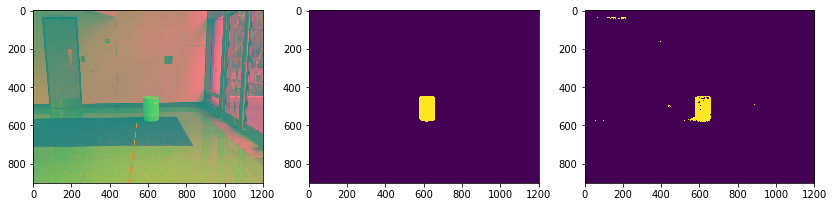

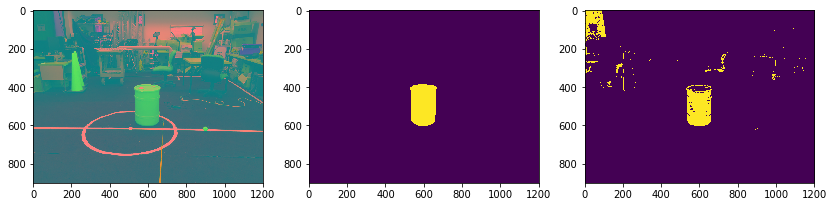

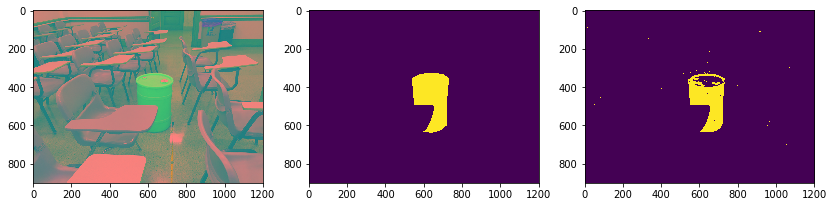

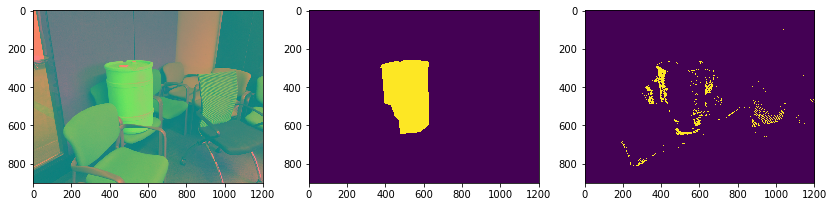

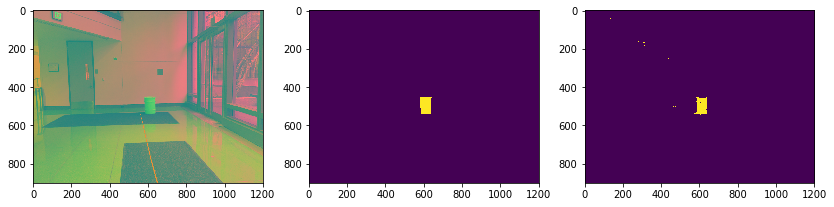

In [313]:
THRESHOLD = 4.5

def test_img_segmentation(test_file, model):
    plt.figure(figsize=(14, 8))
    
    barrel = np.load(BARREL_PATH+test_file+'.npy')
    
    img = cv2.imread(IMG_PATH+test_file+'.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    img_flat = scale(np.reshape(img, (900*1200, 3)))
    
    pred_score = score_samples(img_flat, model) > THRESHOLD
    pred_thresold = list(map(lambda x: 1 if x else 0, pred_score))
    pred_thresold = np.reshape(pred_thresold, (900, 1200))

    plt.subplot(1,3,1)
    plt.imshow(img)
    
    plt.subplot(1,3,2)
    plt.imshow(barrel)
    
    plt.subplot(1,3,3)
    plt.imshow(pred_thresold)
    
    return pred_thresold
    
result_imgs = []
for test_file in test_files:
    result_imgs.append(test_img_segmentation(os.path.splitext(test_file)[0], em_model))

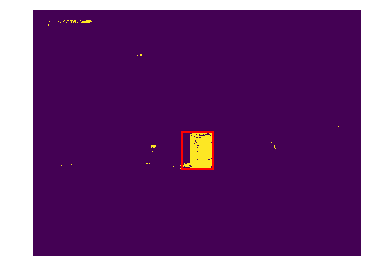

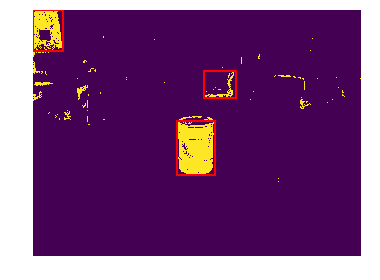

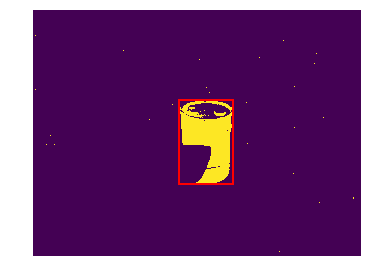

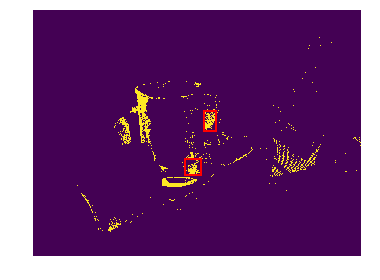

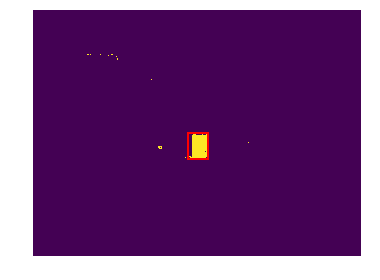

In [314]:
BARREL_RATIO_MAX = 2
BARREL_RATIO_MIN = 0.5
PIXEL_THRESHOLD = 1000
PIXEL_DENSITY = 0.4

def get_barrel_region(test_img):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.imshow(test_img)

    img = util.img_as_ubyte(test_img)
    label_img = label(img, connectivity=img.ndim)

    for region in regionprops(label_img):
        if region.area >= PIXEL_THRESHOLD and region.convex_area/region.bbox_area > PIXEL_DENSITY:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            width = maxc - minc
            height = maxr - minr
            
            if (width/height > BARREL_RATIO_MIN and width/height < BARREL_RATIO_MAX): 
                rect = mpatches.Rectangle((minc, minr), width, height,
                                          fill=False, edgecolor='red', linewidth=2)
                ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

for test_img in result_imgs:
    get_barrel_region(test_img)

In [144]:
from sklearn import mixture

g = mixture.GaussianMixture(n_components=2)

g.fit(xtrain)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

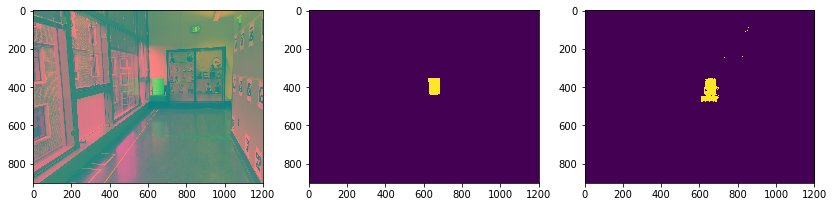

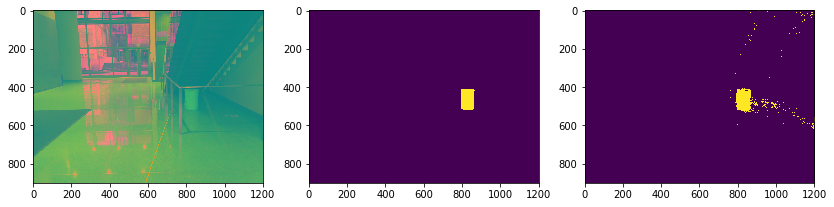

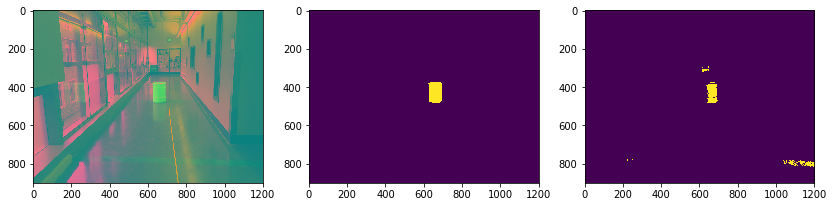

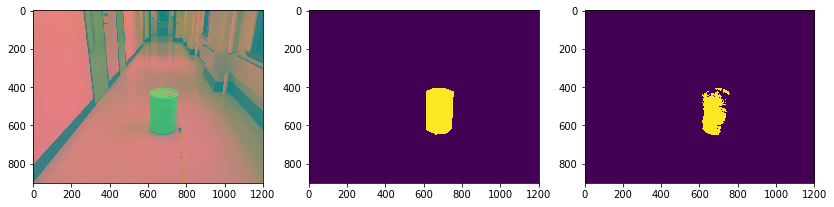

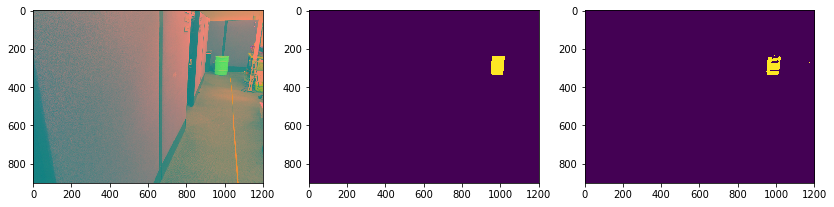

In [275]:
THRESHOLD = -12.5

def test_img_segmentation(test_file):
    plt.figure(figsize=(14, 8))
    
    barrel = np.load(BARREL_PATH+test_file+'.npy')
    
    img = cv2.imread(IMG_PATH+test_file+'.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    img_flat = np.reshape(img, (900*1200, 3))
    
    pred_score = g.score_samples(img_flat) > THRESHOLD
    pred_thresold = list(map(lambda x: 1 if x else 0, pred_score))
    pred_thresold = np.reshape(pred_thresold, (900, 1200))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    
    plt.subplot(1,3,2)
    plt.imshow(barrel)
    
    plt.subplot(1,3,3)
    plt.imshow(pred_thresold)
    
    return pred_thresold
    
result_imgs = []
for test_file in test_files:
    result_imgs.append(test_img_segmentation(os.path.splitext(test_file)[0]))